In [6]:
import lightkurve as lk
%matplotlib inline

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

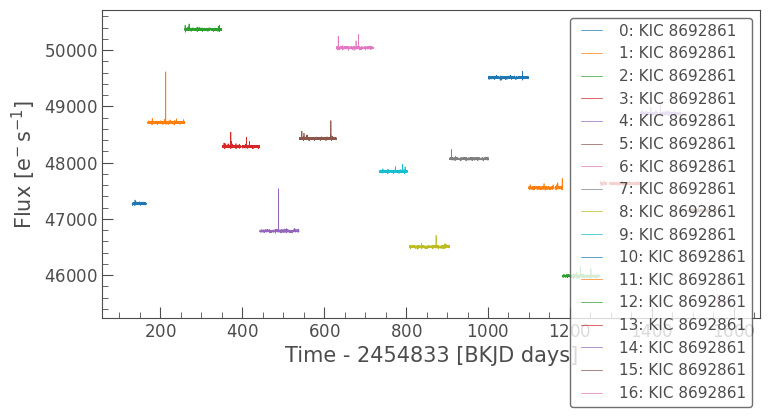

In [7]:
# Searching for Kepler observations of Kepler-69
search = lk.search_lightcurve('Kepler-69', author='Kepler', cadence='long')

# Downloading all available Kepler light curves
light_curves = search.download_all()
light_curves.plot()

The plot shows a series of light curves for the star Kepler-69, as observed by the Kepler space telescope. The light curves are plotted as flux (the intensity of the star's light) over time. The different colors represent different observation periods or quarters during the Kepler mission, with each quarter typically lasting about three months.

Each discrete set of points (separated on the x-axis) corresponds to a different quarter's observation of the star's light curve. The flux is measured in electrons per second, and the time is given in Barycentric Julian Day (BJD) minus a fixed offset (2454833 days in this case).

In order to successfully search this light curve for transits we need to normalize and flatten the full observation.

In [9]:
search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 01,2009,Kepler,1800,kplr008692861,0.0
...,...,...,...,...,...,...
15,Kepler Quarter 16,2013,Kepler,1800,kplr008692861,0.0
16,Kepler Quarter 17,2013,Kepler,1800,kplr008692861,0.0


<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

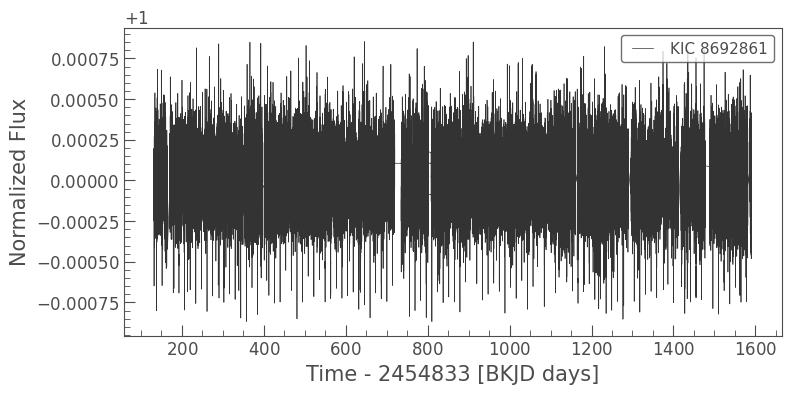

In [10]:
flat_lc = light_curves.stitch().flatten(window_length=901).remove_outliers()
flat_lc.plot()

Box Least Squares (BLS) is an astronomy method used to detect periodic signals, primarily employed in the search for exoplanets. It starts with time-series data of a star's brightness, typically gathered from space telescopes like Kepler or TESS. BLS conducts a systematic search across various trial periods to identify repeating patterns in the light curve. It utilizes a "box function" to model transit signals, with a flat baseline interrupted by a rectangular dip caused by a planet passing in front of the star. The analysis results in a periodogram, with peaks indicating potential exoplanet candidates, and the highest peak denoting the most likely period of the signal.

<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

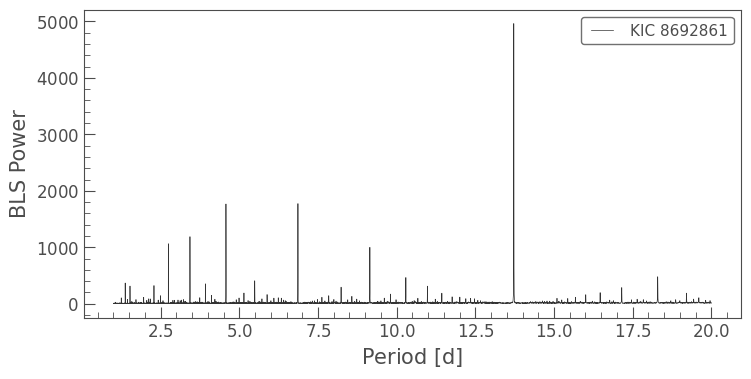

In [13]:
import numpy as np

# Creating an array of periods to search
# Limiting the search to 1-20 days in order to search for short-term planets
period = np.linspace(1, 20, 10000)

# Create a BLS Periodogram
bls_per = flat_lc.to_periodogram(method='bls', period=period, frequency_factor=500)
bls_per.plot()

The plot shows the likelihood of the BLS fit, for each of the periods in the array we passed in. This plot shows a handful of high-power peaks at discrete periods, which is a good sign that a transit has been identified. The highest power spike shows the most likely period, while the lower power spikes are fractional harmonics of the period

In [14]:
# Pulling most likely BLS parameters
planet_b_period = bls_per.period_at_max_power
planet_b_t0 = bls_per.transit_time_at_max_power
planet_b_dur = bls_per.duration_at_max_power

# Looking at the value for period
planet_b_period

<Quantity 13.72177218 d>

We can confirm that this period and transit time correspond to a transit signal by phase-folding the light curve using these values.

(-5.0, 5.0)

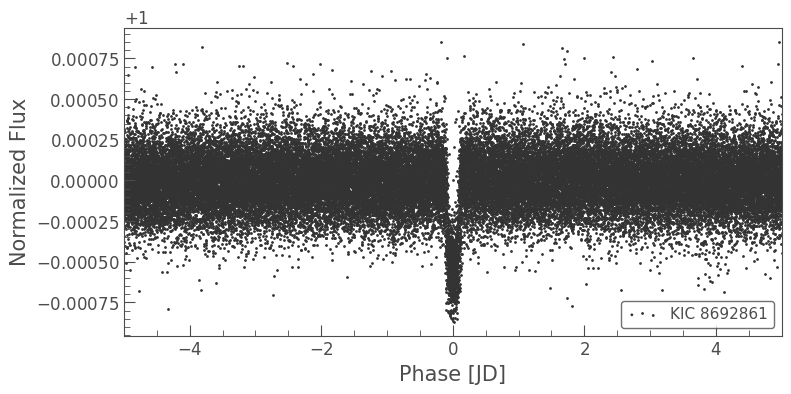

In [16]:
ax = flat_lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()
ax.set_xlim(-5, 5)

With the plot, we can confirm that there is a strong transit signal for the given period and transit time of BLS power.

We can search for the evidence of other planets in the system by masking the previously identified planet_b transit signal. This will allow us to find transits with lover signal-to-noise ratios. 

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

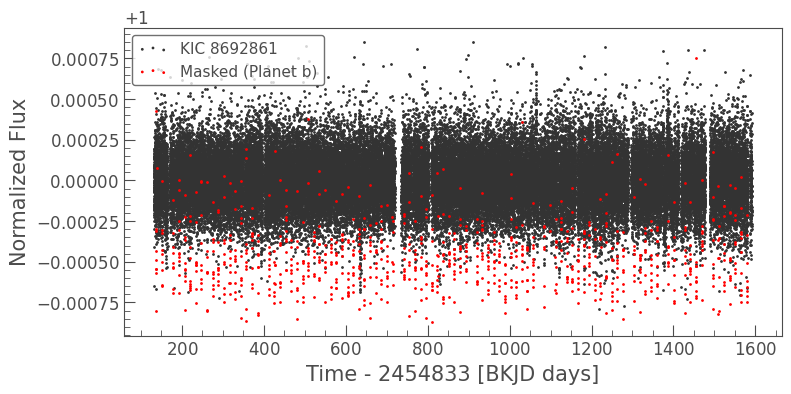

In [19]:
# Create a cadence mask with the BLS parameters
planet_b_mask = bls_per.get_transit_mask(period=planet_b_period, 
                                         transit_time=planet_b_t0, 
                                         duration=planet_b_dur)

# Using the mask, create a new light curve to look for addition transit signals
masked_curve = flat_lc[~planet_b_mask]
ax = masked_curve.scatter()
flat_lc[planet_b_mask].scatter(ax=ax, c='r', label='Masked (Planet b)')

(-5.0, 5.0)

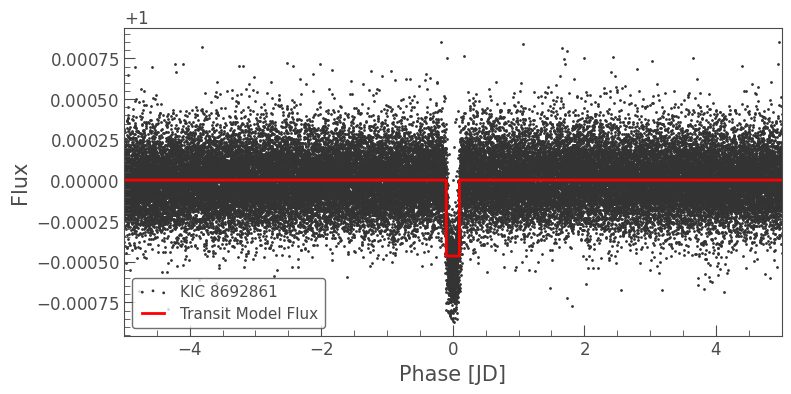

In [21]:
# Create a BLS model to visualize transit fit using the BLS parameters
planet_b_model = bls_per.get_transit_model(period=planet_b_period, 
                                           transit_time=planet_b_t0, 
                                           duration=planet_b_dur)

# Confirm it represents the transit
ax = flat_lc.fold(planet_b_period, planet_b_t0).scatter()
planet_b_model.fold(planet_b_period, planet_b_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-5, 5)

We can now search the remaining light curve for additional transit signals since we masked out the initial transit signal.

<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

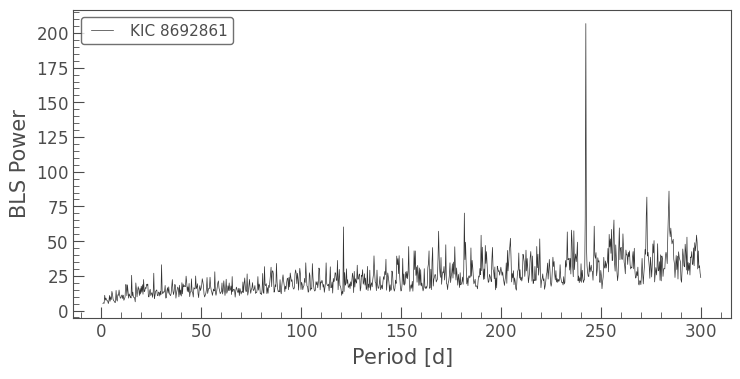

In [23]:
# Increase the limit to 1-300 days to search for longer periods.
period = np.linspace(1, 300, 1000)
bls_per = masked_curve.to_periodogram('bls', period=period, frequency_factor=500)
bls_per.plot()

Now we can now pull the new maximum period and transit time value look for the signal in our masked light curve.

In [24]:
planet_c_period = bls_per.period_at_max_power
planet_c_t0 = bls_per.transit_time_at_max_power
planet_c_dur = bls_per.duration_at_max_power

# Check the value for period
planet_c_period

<Quantity 242.53453453 d>

(-5.0, 5.0)

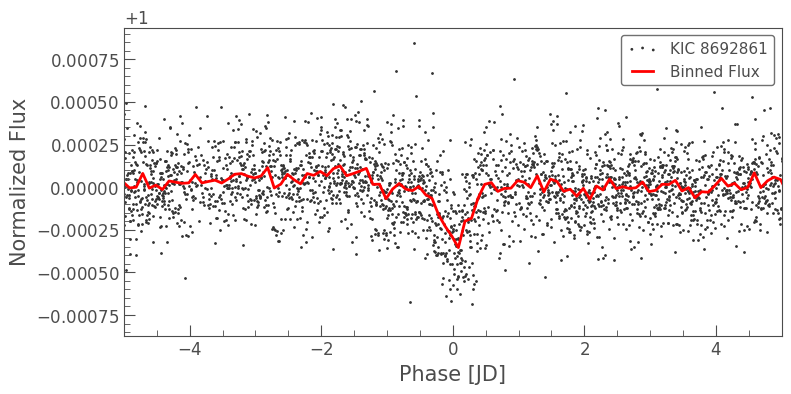

In [33]:
ax = masked_curve.fold(planet_c_period, planet_c_t0).scatter()
masked_curve.fold(planet_c_period, planet_c_t0).bin(.1).plot(ax=ax, 
                                                             c='r', 
                                                             lw=2, 
                                                             label='Binned Flux')

ax.set_xlim(-5, 5)

Due to the longer period of the planet we have a lower SNR, furthermore, the shallower depths imply that the planet is smaller than planet_b.

Using our BLS models, we can visualize the transit timing curve.


In [35]:
planet_c_model = bls_per.get_transit_model(period=planet_c_period,
                                          transit_time=planet_c_t0,
                                          duration=planet_c_dur)

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux'>

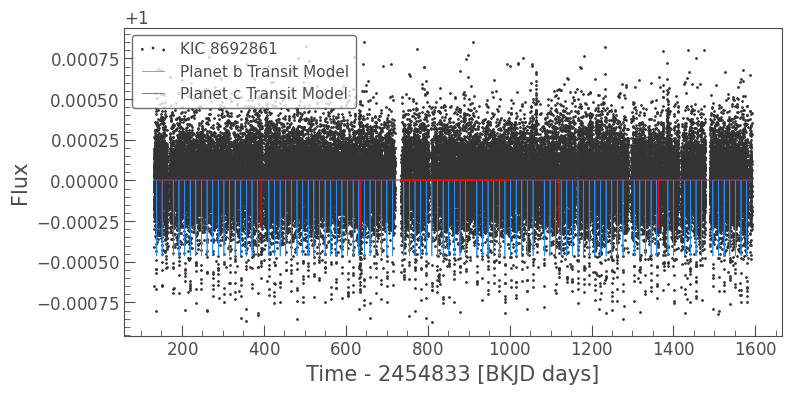

In [36]:
ax = flat_lc.scatter()
planet_b_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model')
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model')